In [2]:
from datetime import datetime, timedelta
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [3]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [4]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

In [47]:
s = time.time()
# data = get_data(get_all_tickers())
data = get_data("BA")
data_cop = data.copy()
print(time.time() - s)

[*********************100%***********************]  1 of 1 completed
1.0194571018218994


### Strategy and more shit

### Parsing initial dataframe

In [6]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling(window_size).max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [7]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"].shift(-1) > df["High52"]
    buy_cond2 = (df.index - df["doh"] < time_thresh2)  & (df.index - df["doh"] > time_thresh1)
    
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    # Sell cond- sell after 3 days, just for testing because I don't know yet how I should do it
    sell_cond = ((df["Close"] - df["Close"].shift(2)) / df["Close"].shift(2)) * 100  # Sell if the percent 2 days ago gone down 3%
    # sell_cond = df["Strategy"].shift(3) == 1
    df.loc[sell_cond, "Strategy"] = -1
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    # df["Stocks bought"] = df["pos"] * s_money//df["Open"]
    # df['Stocks bought'] = df['Stocks bought'].replace(to_replace=np.nan, method='ffill')
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    
    return df

In [48]:
def sim(df1):
    df = df1.copy()
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    return df

In [49]:
df = strategy(parse_data(data_cop))
df = sim(df)
df

,Open,High,Close,Volume,High52,doh,Strategy,pos,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,
1962-01-02,0.84,0.84,0.82,352350,NaN,1900-01-01,0,NaN,NaN,NaN,NaN,NaN
1962-01-03,0.84,0.85,0.84,710775,NaN,1900-01-01,0,NaN,NaN,0.02,NaN,1.02
1962-01-04,0.84,0.85,0.83,911250,NaN,1900-01-01,0,NaN,NaN,-0.01,NaN,1.01
1962-01-05,0.83,0.84,0.81,880875,NaN,1900-01-01,0,NaN,NaN,-0.02,NaN,0.99
1962-01-08,0.81,0.83,0.82,473850,NaN,1900-01-01,0,NaN,NaN,0.00,NaN,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-24,222.51,224.20,217.31,9132600,243.10,2023-08-01,0,0.00,-0.00,-0.05,1.91,264.03
2023-08-25,218.41,223.77,223.41,12346500,243.10,2023-08-01,0,0.00,0.00,0.03,1.91,271.44
2023-08-28,224.21,227.45,227.06,4641800,243.10,2023-08-01,0,0.00,0.00,0.02,1.91,275.88


In [58]:
df["pos"].value_counts()
df.index[df['Strategy'] == 1].tolist()[:10]

[Timestamp('1965-04-14 00:00:00'),
 Timestamp('1965-07-23 00:00:00'),
 Timestamp('1975-03-07 00:00:00'),
 Timestamp('1978-02-08 00:00:00'),
 Timestamp('1979-01-08 00:00:00'),
 Timestamp('1984-08-02 00:00:00'),
 Timestamp('1985-05-31 00:00:00'),
 Timestamp('1985-12-04 00:00:00'),
 Timestamp('1988-05-27 00:00:00'),
 Timestamp('1989-03-14 00:00:00')]

<Axes: xlabel='Date'>

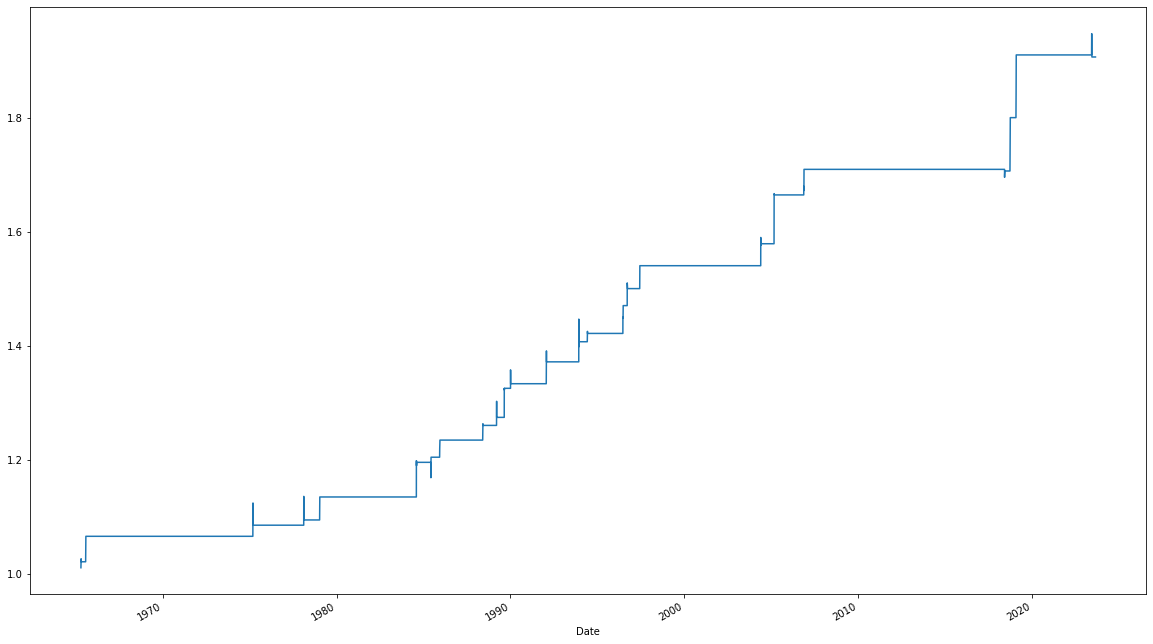

In [50]:
df["sReturn"].plot(figsize=(20,12))

In [57]:
# df[815:835]
df["1965-07-22":"1965-08-05"]

,Open,High,Close,Volume,High52,doh,Strategy,pos,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,
1965-07-22,1.19,1.21,1.20,328050,1.26,1965-04-26,0,0.00,0.00,0.00,1.02,1.45
1965-07-23,1.20,1.23,1.22,1190700,1.26,1965-04-26,1,0.00,0.00,0.02,1.02,1.49
1965-07-26,1.23,1.27,1.27,2381400,1.27,1965-07-26,0,1.00,0.04,0.04,1.06,1.55
1965-07-27,1.27,1.27,1.26,2180925,1.27,1965-07-26,0,1.00,-0.01,-0.01,1.05,1.53
1965-07-28,1.26,1.28,1.28,2430000,1.28,1965-07-28,-1,1.00,0.02,0.02,1.07,1.55
1965-07-29,1.28,1.29,1.27,1293975,1.29,1965-07-29,0,0.00,-0.00,-0.00,1.07,1.55
1965-07-30,1.27,1.29,1.27,844425,1.29,1965-07-29,0,0.00,-0.00,-0.00,1.07,1.54
1965-08-02,1.27,1.28,1.26,850500,1.29,1965-07-29,0,0.00,-0.00,-0.00,1.07,1.53
1965-08-03,1.27,1.30,1.29,1913625,1.30,1965-08-03,0,0.00,0.00,0.02,1.07,1.57


In [175]:
df["pos"].value_counts()

0.00    6587
1.00      27
Name: pos, dtype: int64

In [45]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit   131.00
Hold         130.70
dtype: float64

In [44]:
df["sReturn"].nsmallest(10)

Date
1994-08-30   0.98
1994-08-31   0.98
1994-09-01   0.98
1994-09-02   0.98
1994-09-06   0.98
1994-09-07   0.98
1994-09-08   0.98
1994-09-09   0.98
1994-09-12   0.98
1994-09-13   0.98
Name: sReturn, dtype: float64